# Problema 2

**Grupo 8**
- Anabela Pereira - A87990
- André Gonçalves - A87942

In [1]:
import random as r
from z3 import *
import networkx as nx
from pyscipopt import Model,quicksum

A função criar_circuito cria um grafo orientado para representar um circuito, returnando o grafo, dicionario com a informação sobre os vértices (se são input, gates add, "rsr" ou xor) e também um outro dicionário com a informação sobre os gates "rsr" dizendo o númeoro de bits que rodam de 1 a 15.

In [2]:
def value(s):
    
    if s == "rsr":
        return 1
    else:
        return 2
            
    

def criar_circuito(N,M,Y):
    s = int(Y*M)     # numero de "add"s
    
    inputs = list(range(N))            # inputs
    gates = list(range(N,N+M))        # gates

    k = r.randrange(M-s+1)            # gates XOR
    
    circuito = nx.DiGraph()
 
    labels = {}
    rsr = {}  # valores de r
    
    for v in range(N+M):
        circuito.add_node(v)
        if v<N:
            labels[v]="in"
        elif v<N+s:
            labels[v]="add"
        elif v<N+s+k:
            labels[v]="xor"
        elif v<N+M:
            labels[v]="rsr"
            rsr[v]=r.randrange(1,16)
        
    prio = list(range(N+M)) # os que ainda não têm arcos out
    
    gates = list(range(N,N+M)) # gates
     
    while gates!=[]:
        
        v = r.choice(gates)
        gates.remove(v)
        
        c_prio = prio.copy()
        if v in c_prio:
            c_prio.remove(v)
        
        n = list(circuito.nodes())
        
        for i in c_prio:
            n.remove(i)
        
        n.remove(v)
        
        while c_prio != [] and value(labels[v])>circuito.in_degree(v) :
            v1 = r.choice(c_prio)
            c_prio.remove(v1)
        
            if not nx.has_path(circuito,v,v1) and not circuito.has_edge(v1,v):
                circuito.add_edge(v1,v)
                prio.remove(v1)
        
        
        while n!=[] and value(labels[v])>circuito.in_degree(v):
            v1 = r.choice(n)
            n.remove(v1)
        
            if not nx.has_path(circuito,v,v1) and not circuito.has_edge(v1,v):
                circuito.add_edge(v1,v)     
                            
    return circuito,labels,rsr

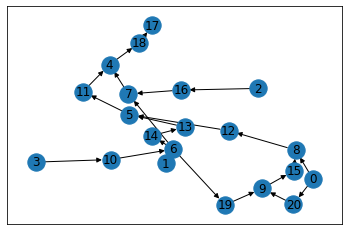

In [3]:
N = 4
M = 17
Y = 4/17
G,labels,rsr = criar_circuito(N,M,Y)

nx.draw_networkx(G) 

inp = [r.choices([0,1],k=16) for i in range(N)]

A próxima função calcula o valor dando o input. É dado para a função o grafo com os arcos invertidos e assim usa recursividade, percorrendo o grafo começando do último gate, gate que vai dar o output final.

In [4]:

def xor(a,b):
    return [a[i] ^ b[i] for i in range(16)]
    
    
def rotate(a,n):
    i=len(a)-n
    return a[i:]+a[:i]
    

def soma(b,c):
    carry = False
    r = [False]*16
    for i in range(15,-1,-1):
        r[i] = (b[i]^ c[i]) ^ carry
        carry = (c[i] and b[i]) or ((c[i] or b[i]) and carry)
    return r


print("Labels:",labels)
print("Valores do rsr:",rsr)

def percorre(v,circuito,inp,labels,rsr,somas):
    
    if labels[v] == "in":
        return inp[v]
    
    elif labels[v] == "add":
        l = list(circuito[v])
        somas[v]= soma(percorre(l[0],circuito,inp,labels,rsr,somas),percorre(l[1],circuito,inp,labels,rsr,somas))
        return somas[v]
    
    elif labels[v] == "xor":
        v = list(circuito[v])
        return xor(percorre(v[0],circuito,inp,labels,rsr,somas),percorre(v[1],circuito,inp,labels,rsr,somas))
    
    else: # labels(v) == "rsr":
        l = list(circuito[v])
        return rotate(percorre(l[0],circuito,inp,labels,rsr,somas),rsr[v])
    

def calcula(inp,circuito,labels,rsr):
    
    somas={}
    
    for v in circuito.nodes():
        if circuito.in_degree(v) == 0:
            inicial = v
            break
            
    return percorre(v,circuito,inp,labels,rsr,somas),somas

out,somas = calcula(inp,G.reverse(),labels,rsr)



Labels: {0: 'in', 1: 'in', 2: 'in', 3: 'in', 4: 'add', 5: 'add', 6: 'add', 7: 'add', 8: 'xor', 9: 'xor', 10: 'rsr', 11: 'rsr', 12: 'rsr', 13: 'rsr', 14: 'rsr', 15: 'rsr', 16: 'rsr', 17: 'rsr', 18: 'rsr', 19: 'rsr', 20: 'rsr'}
Valores do rsr: {10: 6, 11: 8, 12: 2, 13: 3, 14: 14, 15: 12, 16: 3, 17: 7, 18: 9, 19: 8, 20: 12}


A função que calcula os possíveis inputs dando o output é estruturalmente semelhante á anterior. São utilizados bits vectors e lógica proposicional do Z3 para calcular os outputs.

In [5]:
def fromBin(a):# converte uma lista de 16 bits para um inteiro
    r = 0
    for i in range(16):
        r = 2*r
        if (a[i]==1):
            r = r+1
    return r
   
def toBin(a): # converte para binario
    r = []
    for _ in range(16):
        r.insert(0,'1' if a%2==1 else '0')
        a = a//2
    return ''.join(r)

    
def rotate_z3(r,n):
    return ((r<<(16-n)) | LShR(r,n))
   
def percorre_z3(v,circuito,labels,rsr,somas,inp,sol):
    
    if labels[v] == "in":
        return inp[v]
    
    elif labels[v] == "add":
        l = list(circuito[v])
        obj=percorre_z3(l[0],circuito,labels,rsr,somas,inp,sol) + percorre_z3(l[1],circuito,labels,rsr,somas,inp,sol)
        sol.add(BitVecVal(fromBin(somas[v]),16)==obj)
        return obj
    
    elif labels[v] == "xor":
        v = list(circuito[v])
        return (percorre_z3(v[0],circuito,labels,rsr,somas,inp,sol) ^ percorre_z3(v[1],circuito,labels,rsr,somas,inp,sol))
    
    else: # labels(v) == "rsr":
        l = list(circuito[v])
        return rotate_z3(percorre_z3(l[0],circuito,labels,rsr,somas,inp,sol),rsr[v])


    
def inv_calcula(out,circuito,labels,rsr,somas,N):

    out = BitVecVal(fromBin(out),16)
    
    inp = [BitVec(str(i), 16) for i in range(N)]
    
    sol = Solver()
    
    for v in circuito.nodes():
        if circuito.in_degree(v) == 0:
            inicial = v
            break
    
    sol.add(out == percorre_z3(v,circuito,labels,rsr,somas,inp,sol))
    
    r = {}
    c = 0
    while sol.check() == sat:
        m = sol.model()
        r[c]=[]
        for i in inp:
            r[c].append(toBin(m[i].as_long()))
    
        sol.add(Or([m[i] != i for i in inp]))
        c+=1
        if c>15: # só vai até 15 possíveis inputs
            break
        
    return r

print("input:",inp)
print("output:",out)

print("Possíveis inputs:",inv_calcula(out,G.reverse(),labels,rsr,somas,N))

input: [[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1], [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1], [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]]
output: [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
Possíveis inputs: {0: ['1010000000011011', '0010011111001001', '0010001110101011', '1110000000100100'], 1: ['1011001100001000', '1010100111101001', '0010001110101011', '0101100000000100'], 2: ['1111001101001000', '1010100111101001', '0010001110101011', '0101100000000100'], 3: ['1111001101001000', '0010100111101001', '0010001110101011', '0101100000100100'], 4: ['1111011101001100', '0010100111101001', '0010001110101011', '0101100000100100'], 5: ['1111011101001100', '1010100111101001', '0010001110101011', '0101100000000100'], 6: ['1111111101000100', '1010100111101001', '0010001110101011', '0101100000000100'], 7: ['1111111101000100', '0010100111101001', '0010001110101011', '0101100000100100'], 8: ['1101111101100100', '00101001111